In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, LSTM, Dense, GRU
from tensorflow.keras import Sequential, Model

In [2]:
!bzip2 -ckd "/content/drive/MyDrive/Datasets/5G Network Performance/clean_data.csv.bz2" > clean_data.csv

In [198]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('clean_data.csv')
df.head()

,time,Convert_time,DATES,TIME,DAY,YEAR,MONTH,DATE,HOUR,MIN,SEC,latitude,longitude,svr1,svr2,svr3,svr4,upload_transfer_size_mbytes,upload_bitrate_mbits/sec,download_transfer_size_rx_mbytes,download_bitrate_rx_mbits/sec,application_data,square_id
0,1656877417,2022-07-04 05:43:37,2022-07-04,05:43:37,Monday,2022,7,4,5,43,37,-37.712603,144.859029,23.0,24.4,28.4,49.8,1.91,16.10,0.840820,7.06,0.005067,square_111669149772
1,1656877418,2022-07-04 05:43:38,2022-07-04,05:43:38,Monday,2022,7,4,5,43,38,-37.712627,144.859119,43.2,47.0,44.0,55.2,1.85,15.50,0.864258,7.25,0.005664,square_111669149772
2,1656877419,2022-07-04 05:43:39,2022-07-04,05:43:39,Monday,2022,7,4,5,43,39,-37.712695,144.859188,57.0,54.8,47.2,69.1,1.91,16.10,0.947266,7.95,0.004143,square_111669149772
3,1656877424,2022-07-04 05:43:44,2022-07-04,05:43:44,Monday,2022,7,4,5,43,44,-37.712993,144.859051,27.7,34.8,36.1,44.5,1.11,9.33,1.270000,10.70,0.007172,square_111669149772
4,1656877425,2022-07-04 05:43:45,2022-07-04,05:43:45,Monday,2022,7,4,5,43,45,-37.713143,144.859034,26.0,23.1,21.4,44.4,1.48,12.40,1.690000,14.20,0.004509,square_111669149772


In [199]:
features = [
    'svr1',
    'svr2',
    'svr3',
    'svr4',
    'upload_bitrate_mbits/sec',
    'download_bitrate_rx_mbits/sec'
]

for feature in features:
    df[feature] = df[feature].replace([0, 1000], np.nan).ffill()

df.dropna(inplace=True)
df.head()

,time,Convert_time,DATES,TIME,DAY,YEAR,MONTH,DATE,HOUR,MIN,SEC,latitude,longitude,svr1,svr2,svr3,svr4,upload_transfer_size_mbytes,upload_bitrate_mbits/sec,download_transfer_size_rx_mbytes,download_bitrate_rx_mbits/sec,application_data,square_id
0,1656877417,2022-07-04 05:43:37,2022-07-04,05:43:37,Monday,2022,7,4,5,43,37,-37.712603,144.859029,23.0,24.4,28.4,49.8,1.91,16.10,0.840820,7.06,0.005067,square_111669149772
1,1656877418,2022-07-04 05:43:38,2022-07-04,05:43:38,Monday,2022,7,4,5,43,38,-37.712627,144.859119,43.2,47.0,44.0,55.2,1.85,15.50,0.864258,7.25,0.005664,square_111669149772
2,1656877419,2022-07-04 05:43:39,2022-07-04,05:43:39,Monday,2022,7,4,5,43,39,-37.712695,144.859188,57.0,54.8,47.2,69.1,1.91,16.10,0.947266,7.95,0.004143,square_111669149772
3,1656877424,2022-07-04 05:43:44,2022-07-04,05:43:44,Monday,2022,7,4,5,43,44,-37.712993,144.859051,27.7,34.8,36.1,44.5,1.11,9.33,1.270000,10.70,0.007172,square_111669149772
4,1656877425,2022-07-04 05:43:45,2022-07-04,05:43:45,Monday,2022,7,4,5,43,45,-37.713143,144.859034,26.0,23.1,21.4,44.4,1.48,12.40,1.690000,14.20,0.004509,square_111669149772


In [200]:
df['Date Time'] = pd.to_datetime(df['DATES'] + ' ' + df['TIME'])
df.head()

,time,Convert_time,DATES,TIME,DAY,YEAR,MONTH,DATE,HOUR,MIN,SEC,latitude,longitude,svr1,svr2,svr3,svr4,upload_transfer_size_mbytes,upload_bitrate_mbits/sec,download_transfer_size_rx_mbytes,download_bitrate_rx_mbits/sec,application_data,square_id,Date Time
0,1656877417,2022-07-04 05:43:37,2022-07-04,05:43:37,Monday,2022,7,4,5,43,37,-37.712603,144.859029,23.0,24.4,28.4,49.8,1.91,16.10,0.840820,7.06,0.005067,square_111669149772,2022-07-04 05:43:37
1,1656877418,2022-07-04 05:43:38,2022-07-04,05:43:38,Monday,2022,7,4,5,43,38,-37.712627,144.859119,43.2,47.0,44.0,55.2,1.85,15.50,0.864258,7.25,0.005664,square_111669149772,2022-07-04 05:43:38
2,1656877419,2022-07-04 05:43:39,2022-07-04,05:43:39,Monday,2022,7,4,5,43,39,-37.712695,144.859188,57.0,54.8,47.2,69.1,1.91,16.10,0.947266,7.95,0.004143,square_111669149772,2022-07-04 05:43:39
3,1656877424,2022-07-04 05:43:44,2022-07-04,05:43:44,Monday,2022,7,4,5,43,44,-37.712993,144.859051,27.7,34.8,36.1,44.5,1.11,9.33,1.270000,10.70,0.007172,square_111669149772,2022-07-04 05:43:44
4,1656877425,2022-07-04 05:43:45,2022-07-04,05:43:45,Monday,2022,7,4,5,43,45,-37.713143,144.859034,26.0,23.1,21.4,44.4,1.48,12.40,1.690000,14.20,0.004509,square_111669149772,2022-07-04 05:43:45


In [201]:
df = df[[
    'svr1',
    'svr2',
    'svr3',
    'svr4',
    'upload_bitrate_mbits/sec',
    'download_bitrate_rx_mbits/sec',
    'Date Time'
]]
df.head()

,svr1,svr2,svr3,svr4,upload_bitrate_mbits/sec,download_bitrate_rx_mbits/sec,Date Time
0,23.0,24.4,28.4,49.8,16.10,7.06,2022-07-04 05:43:37
1,43.2,47.0,44.0,55.2,15.50,7.25,2022-07-04 05:43:38
2,57.0,54.8,47.2,69.1,16.10,7.95,2022-07-04 05:43:39
3,27.7,34.8,36.1,44.5,9.33,10.70,2022-07-04 05:43:44
4,26.0,23.1,21.4,44.4,12.40,14.20,2022-07-04 05:43:45


In [202]:
df = df.groupby('Date Time').agg('mean')
df.head()

,svr1,svr2,svr3,svr4,upload_bitrate_mbits/sec,download_bitrate_rx_mbits/sec
Date Time,,,,,,
2022-07-04 05:31:26,65.2,62.5,61.0,84.0,21.0,73.1
2022-07-04 05:31:27,65.2,62.5,61.0,84.0,21.0,73.1
2022-07-04 05:31:28,65.2,62.5,61.0,84.0,21.0,73.1
2022-07-04 05:31:29,65.2,62.5,61.0,84.0,21.0,73.1
2022-07-04 05:31:30,65.2,62.5,61.0,84.0,21.0,73.1


In [203]:
df['Average Server Latency'] = df[['svr1', 'svr2', 'svr3', 'svr4']].mean(axis=1)
df['Total Throughput'] = df['upload_bitrate_mbits/sec'] + df['download_bitrate_rx_mbits/sec']
df.head()

,svr1,svr2,svr3,svr4,upload_bitrate_mbits/sec,download_bitrate_rx_mbits/sec,Average Server Latency,Total Throughput
Date Time,,,,,,,,
2022-07-04 05:31:26,65.2,62.5,61.0,84.0,21.0,73.1,68.175,94.1
2022-07-04 05:31:27,65.2,62.5,61.0,84.0,21.0,73.1,68.175,94.1
2022-07-04 05:31:28,65.2,62.5,61.0,84.0,21.0,73.1,68.175,94.1
2022-07-04 05:31:29,65.2,62.5,61.0,84.0,21.0,73.1,68.175,94.1
2022-07-04 05:31:30,65.2,62.5,61.0,84.0,21.0,73.1,68.175,94.1


In [204]:
features = [
    'Average Server Latency',
    'Total Throughput'
]

df = df[features]
df.head()

,Average Server Latency,Total Throughput
Date Time,,
2022-07-04 05:31:26,68.175,94.1
2022-07-04 05:31:27,68.175,94.1
2022-07-04 05:31:28,68.175,94.1
2022-07-04 05:31:29,68.175,94.1
2022-07-04 05:31:30,68.175,94.1


In [205]:
df = df.resample('1min').mean().dropna()
df.head()

,Average Server Latency,Total Throughput
Date Time,,
2022-07-04 05:31:00,64.383333,82.122963
2022-07-04 05:32:00,71.725472,29.877170
2022-07-04 05:33:00,69.972596,38.670962
2022-07-04 05:34:00,75.964904,32.866923
2022-07-04 05:35:00,136.857075,26.694340


In [206]:
months_in_year = 12
df['Month (Sin)'] = np.sin(2 * np.pi * df.index.month / months_in_year)
df['Month (Cos)'] = np.cos(2 * np.pi * df.index.month / months_in_year)

days_in_month = 30
df['Day (Sin)'] = np.sin(2 * np.pi * df.index.day / days_in_month)
df['Day (Cos)'] = np.cos(2 * np.pi * df.index.day / days_in_month)

hours_in_day = 24
df['Hour (Sin)'] = np.sin(2 * np.pi * df.index.hour / hours_in_day)
df['Hour (Cos)'] = np.cos(2 * np.pi * df.index.hour / hours_in_day)

minutes_in_hour = 60
df['Minute (Sin)'] = np.sin(2 * np.pi * df.index.minute / minutes_in_hour)
df['Minute (Cos)'] = np.cos(2 * np.pi * df.index.minute / minutes_in_hour)

df.head()

,Average Server Latency,Total Throughput,Month (Sin),Month (Cos),Day (Sin),Day (Cos),Hour (Sin),Hour (Cos),Minute (Sin),Minute (Cos)
Date Time,,,,,,,,,,
2022-07-04 05:31:00,64.383333,82.122963,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.104528,-0.994522
2022-07-04 05:32:00,71.725472,29.877170,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.207912,-0.978148
2022-07-04 05:33:00,69.972596,38.670962,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.309017,-0.951057
2022-07-04 05:34:00,75.964904,32.866923,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.406737,-0.913545
2022-07-04 05:35:00,136.857075,26.694340,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.500000,-0.866025


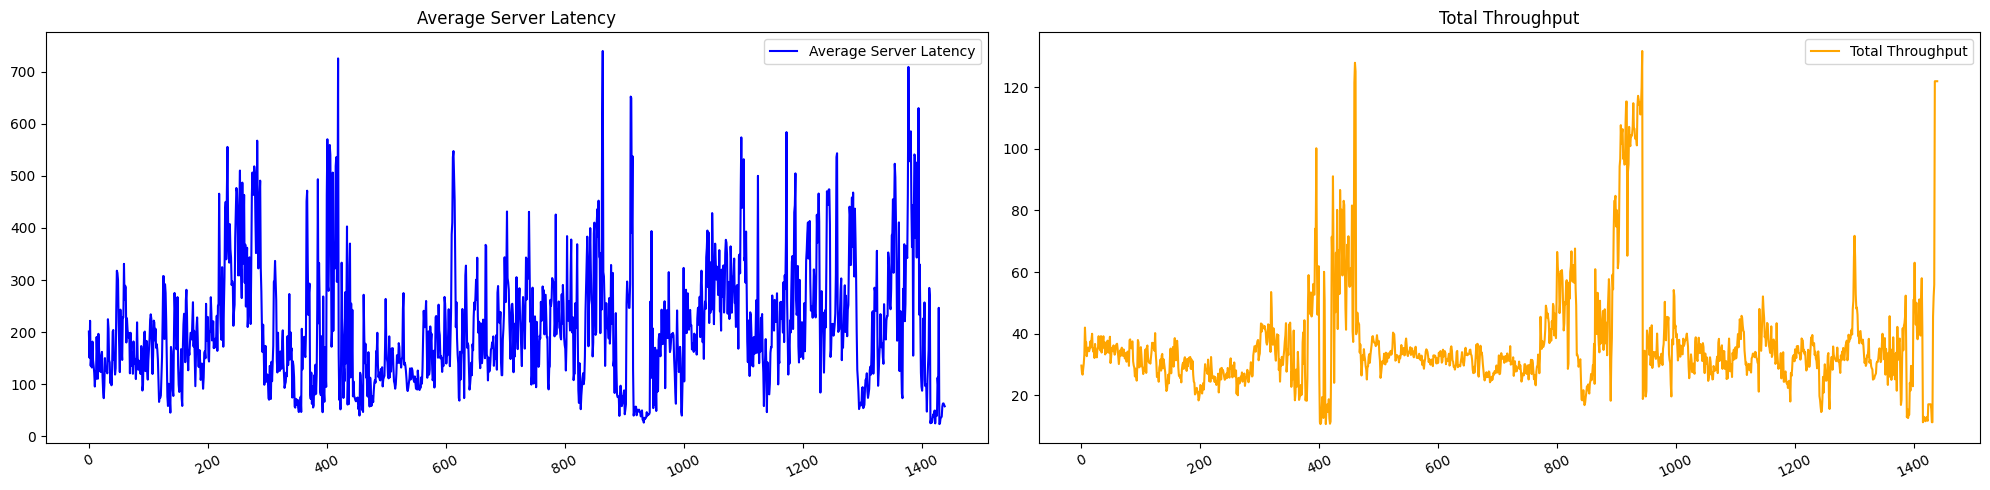

In [207]:
features = [
    ('Average Server Latency', 'blue'),
    ('Total Throughput', 'orange'),
]

def visualise_data(data):
    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(20, 5)
    )

    for i in range(len(features)):
        key, color = features[i]
        t_data = data[key].tail(60 * 24)
        ax = t_data.plot(
            use_index=False,
            ax=axes[i],
            color=color,
            title=key,
            rot=25
        )

        ax.legend([key])

    plt.tight_layout()

visualise_data(df)

In [208]:
sampling_rate = 1

train_size = 0.8
train_split = int(train_size * int(df.shape[0]))

past = 60
future = 1
batch_size = 256
epochs = 40

In [209]:
selected_features = [
    'Month (Sin)',
    'Month (Cos)',
    'Day (Sin)',
    'Day (Cos)',
    'Hour (Sin)',
    'Hour (Cos)',
    'Minute (Sin)',
    'Minute (Cos)',
    'Average Server Latency',
    'Total Throughput'
]

features = df[selected_features]
features.head()

,Month (Sin),Month (Cos),Day (Sin),Day (Cos),Hour (Sin),Hour (Cos),Minute (Sin),Minute (Cos),Average Server Latency,Total Throughput
Date Time,,,,,,,,,,
2022-07-04 05:31:00,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.104528,-0.994522,64.383333,82.122963
2022-07-04 05:32:00,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.207912,-0.978148,71.725472,29.877170
2022-07-04 05:33:00,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.309017,-0.951057,69.972596,38.670962
2022-07-04 05:34:00,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.406737,-0.913545,75.964904,32.866923
2022-07-04 05:35:00,-0.5,-0.866025,0.743145,0.669131,0.965926,0.258819,-0.500000,-0.866025,136.857075,26.694340


In [210]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6,7,8,9
0,1.0,1.0,0.52635,1.730346,0.952205,2.048031,-0.139795,-1.408406,-0.953109,2.903969
1,1.0,1.0,0.52635,1.730346,0.952205,2.048031,-0.285516,-1.385171,-0.886046,-0.313490
2,1.0,1.0,0.52635,1.730346,0.952205,2.048031,-0.428026,-1.346729,-0.902057,0.228059
3,1.0,1.0,0.52635,1.730346,0.952205,2.048031,-0.565763,-1.293501,-0.847323,-0.129372
4,1.0,1.0,0.52635,1.730346,0.952205,2.048031,-0.697219,-1.226069,-0.291135,-0.509499


In [211]:
train_data = features.loc[0:train_split - 1]
val_data = features.loc[train_split:]

In [212]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(len(selected_features))]].values
y_train = features.iloc[start:end][[9]]

sequence_length = int(past / sampling_rate)

training_dataset = timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size
)

In [213]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_validation = val_data.iloc[:x_end][[i for i in range(len(selected_features))]].values
y_validation = features.iloc[label_start:][[9]]

validation_dataset = timeseries_dataset_from_array(
    x_validation,
    y_validation,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size
)

In [214]:
for batch in validation_dataset.take(1):
    inputs, targets = batch

print("Input shape:", inputs.shape)
print("Target shape:", targets.shape)

Input shape: (256, 60, 10)
Target shape: (256, 1)


In [217]:
# Build the LSTM model
inputs = Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = GRU(32)(inputs)
outputs = Dense(1)(lstm_out)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(), loss='mse')
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 60, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 32)                  │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,257 (16.63 KB)

 Trainable params: 4,257 (16.63 KB)

 Non-trainable params: 0 (0.00 B)

In [218]:
path_checkpoint = "timeseries_model_lstm.weights.h5"
es_callback = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    training_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=[es_callback, modelckpt_callback]
)

Epoch 1/40
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.7528
Epoch 1: val_loss improved from inf to 0.54295, saving model to timeseries_model_lstm.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.7469 - val_loss: 0.5430
Epoch 2/40
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.4054
Epoch 2: val_loss improved from 0.54295 to 0.40273, saving model to timeseries_model_lstm.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.4052 - val_loss: 0.4027
Epoch 3/40
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.3218
Epoch 3: val_loss improved from 0.40273 to 0.36534, saving model to timeseries_model_lstm.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.3222 - val_loss: 0.3653
Epoch 4/40
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.2996
Epoch 4: val_loss improved from 0.36534 to 0.35080, saving model to timeseries_model_lstm.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.3000 - val_loss: 0.3508
Epoch 5/40
24/25 ━━━━━━━━━━━━━━━━━━━

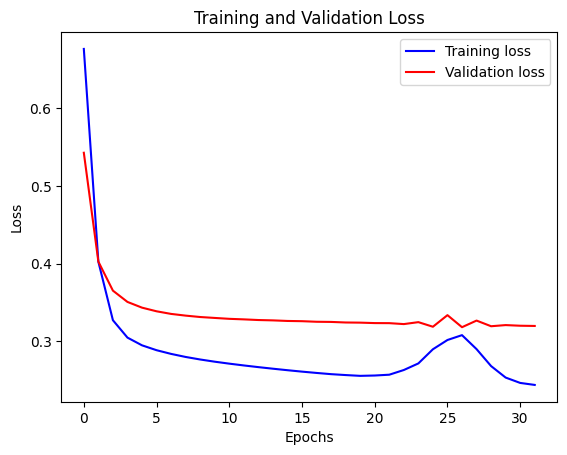

In [219]:
def visualize_loss(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

visualize_loss(history, 'Training and Validation Loss')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


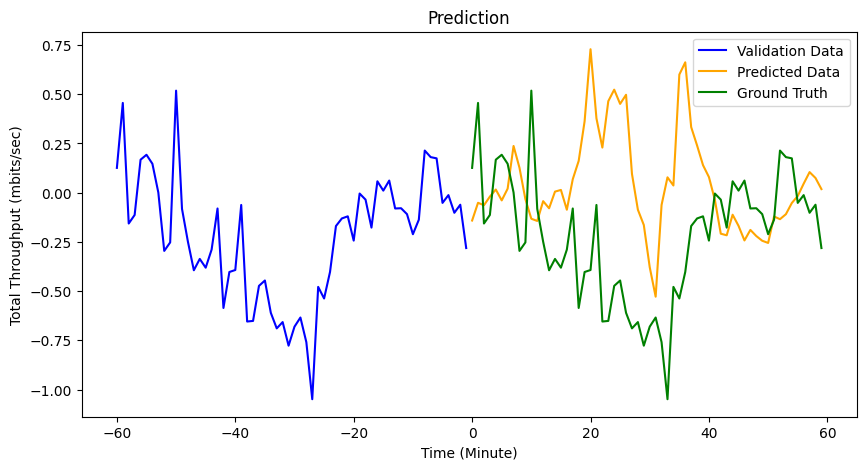

In [223]:
predictions = []
ground_truth = []

for batch in validation_dataset.skip(4).take(1):
    inputs, targets = batch
    preds = model.predict(inputs)
    predictions.extend(preds.flatten())
    ground_truth.extend(targets.numpy().flatten())

predictions = np.array(predictions)
ground_truth = np.array(ground_truth)

data_duration = 60
prediction_duration = 60

validation_data = ground_truth[-data_duration:]
prediction = predictions[:prediction_duration]
ground_truth = ground_truth[-data_duration:][:prediction_duration]

plt.figure(figsize=(10, 5))

plt.plot(range(-data_duration, 0), validation_data, color='blue', label="Validation Data")
plt.plot(range(0, prediction_duration), prediction, color='orange', label="Predicted Data")
plt.plot(range(0, prediction_duration), ground_truth, color='green', label="Ground Truth")

plt.title('Prediction')
plt.xlabel('Time (Minute)')
plt.ylabel('Total Throughput (mbits/sec)')
plt.legend()

plt.show()